In [1]:
import numpy as np
import pandas as pd

# Load and clean up data

In [2]:
df_all = pd.read_csv(r'C:\Users\fyang\CCS-Prediction-Publish\CCS_prediction\PredictionCCS.csv')

In [3]:
df_all['SMILES'].isnull().values.any()
df_all = df_all.dropna(subset=['SMILES', 'CCS'])

In [4]:
from rdkit import Chem
from rdkit.Chem import PandasTools

# get fingerprints
def get_FPs(df):
    
    # from SMILES to mol
    PandasTools.AddMoleculeColumnToFrame(df,
                                         'SMILES','Molecules',
                                         includeFingerprints = True)
    df.dropna(subset = ['Molecules'],inplace = True)
    df = df.reset_index()
    # from mol to FPs
    df['FPs'] =[Chem.RDKFingerprint(mol, fpSize = 1024) for mol in df.Molecules]
    
    return df

In [5]:
df_all= get_FPs(df_all)

In [6]:
FPs = df_all['FPs'].tolist()

In [7]:
# Clean up data
df_all.drop_duplicates(subset=['SMILES','adduct','CCS'], inplace = True)

In [48]:
df_all.shape[0]

13324

In [55]:
subdf_all = df_all.drop_duplicates(subset=['FPs','CCS'])
subdf_all.shape[0]

13324

,index,CID,SMILES,adduct,CCS,Super.Class,Source,Molecules,FPs
0,0,14410,C1(=C(C(=C(C(=C1Br)Br)Br)Br)Br)OC2=C(C(=C(C(=C...,[M+H]+,205.23,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,1,16318,C1(=C(C(=C(C(=C1Cl)Cl)Cl)Cl)Cl)C2=C(C(=C(C(=C2...,[M+H]+,185.88,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,2,45472,C1=C(C(=C(C(=C1Br)Br)Br)Br)OC2=C(C(=C(C(=C2Br)...,[M+H]+,202.77,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,3,40484,C1=C(C(=C(C(=C1Cl)Cl)C2=C(C(=C(C(=C2Cl)Cl)Cl)C...,[M+H]+,182.07,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,4,16495,C1=C(C(=C(C(=C1Cl)Cl)C2=C(C(=CC(=C2Cl)Cl)Cl)Cl...,[M+H]+,176.90,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."

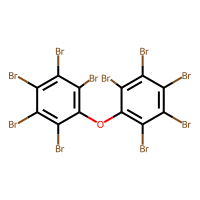
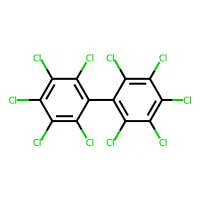
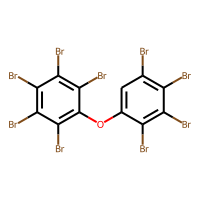
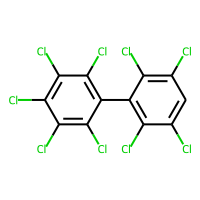
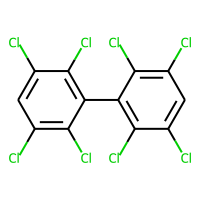

In [8]:
df_all.head(5)

# Tuning

In [13]:
# Random Forest Regression tuning
# Approach 1 CCS prediction without classification

from sklearn.model_selection import train_test_split

X_all = df_all['FPs'].tolist()
y_all = df_all['CCS'].values

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, 
                                                                train_size = 0.8, 
                                                                test_size=0.2, 
                                                                random_state=101,
                                                                )

print('X_Re_train: {}'.format(np.shape(X_all_train)))
print('y_Re_train: {}'.format(np.shape(y_all_train)))
print('X_Re_test: {}'.format(np.shape(X_all_test)))
print('y_Re_test: {}'.format(np.shape(y_all_test)))

X_Re_train: (10659, 1024)
y_Re_train: (10659,)
X_Re_test: (2665, 1024)
y_Re_test: (2665,)


In [14]:
from sklearn.ensemble import RandomForestRegressor

#Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Quality of a split
criterion = ['squared_error']
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [None]
# Minimum number of samples required to split a node
#min_samples_split2 = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]
# Use out-of-bag samples to estimate the generalization score. 
oob_score = [True]

In [15]:
# Creat the param grid
param_grid = {'n_estimators': n_estimators,
              #'criterion': criterion,
              #'max_features': max_features,
              #'max_depth': max_depth,
              #'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             # 'oob_score': oob_score
               }
# Define model type
rfr_Model = RandomForestRegressor(oob_score = [True])

In [16]:
from sklearn.model_selection import GridSearchCV


rfr_Grid = GridSearchCV(estimator = rfr_Model, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = 3,
                       return_train_score = True
                       )


rfr_Grid.fit(X_all_train, y_all_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=[True]), n_jobs=3,
             param_grid={'min_samples_leaf': [5, 8, 12, 16, 20],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                          411, 455, 500]},
             return_train_score=True, verbose=2)

In [17]:
# Optimized method 
print(rfr_Grid.best_params_)
print (f'Train Accuracy - : {rfr_Grid.score(X_all_train,y_all_train):.3f}')
print (f'Test Accuracy - : {rfr_Grid.score(X_all_test,y_all_test):.3f}')

{'min_samples_leaf': 5, 'n_estimators': 366}
Train Accuracy - : 0.973
Test Accuracy - : 0.958


In [191]:
# Save model
import joblib
filename = 'Direct_CCSprediction_final.joblib'
joblib.dump(rfr_Grid, filename)

['Direct_CCSprediction_final.joblib']

In [192]:
#save train test data set

output = {}

output['X_train_shape'] = np.shape(X_all_train)
output['X_test_shape'] = np.shape(X_all_test)
output['y_train_shape'] = np.shape(y_all_train) 
output['y_test_shape'] = np.shape(y_all_test)
output['X_test'] = X_all_test
output['y_test'] = y_all_test
output['X_train'] = X_all_test

filename = 'summary_DirectGridR.joblib'
joblib.dump(output, filename)

['summary_DirectGridR.joblib']

In [25]:
testData = df_all[df_all.FPs.isin(X_all_test)]
print(testData.shape[0])
print(output['X_test_shape'])

2708
(2665, 1024)


In [92]:
testData = df_all[(df_all.FPs.isin(X_all_test)) & df_all.CCS.isin(y_all_test)]
print(testData.shape[0])
print(output['X_test_shape'])

2688
(2665, 1024)


In [118]:
testData.to_csv('Testset_all.csv',index=False)

# GridSearch CV

In [94]:
# Plot grid results
import matplotlib.pyplot as plt
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    #fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='-', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

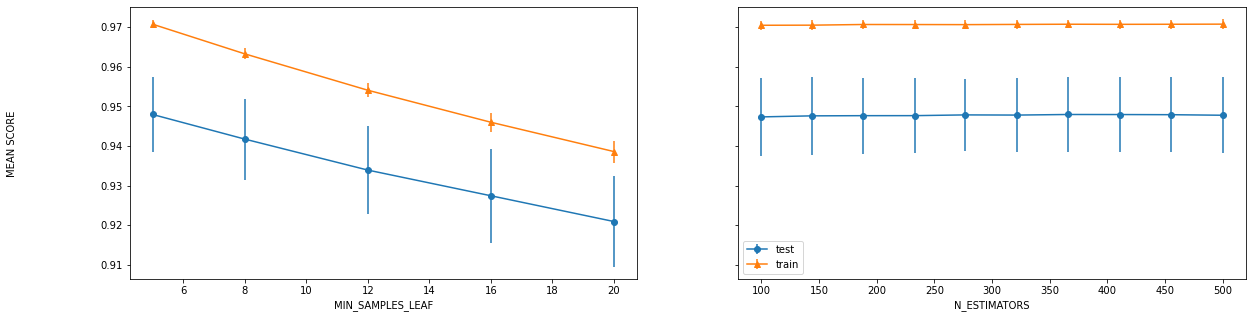

In [95]:
plot_search_results(rfr_Grid)

In [34]:
from sklearn.tree import export_graphviz

def plotTrees(Grid, label):
    Grid_opt = Grid.best_estimator_
    for index in range(0, 5):
        export_graphviz(Grid_opt[index], out_file=label+str(index)+'.dot', 
                #feature_names = fn,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [36]:
plotTrees(rfr_Grid, 'DirectPred')

In [37]:
# Calculate feature importances
def plotFI(Grid, label):
    Grid_opt = Grid.best_estimator_
    importances = Grid_opt.feature_importances_
    # investigate the top 5 importance features
    ind = np.argpartition(importances,-5)[-5:] 
    print(ind)
    print(importances[ind])
    plt.plot(importances)
    #plt.ylim([0, importances])
    plt.title('Feaure_importances 0f '+ label)
    plt.xlabel('Features_FPs_1024bits')
    plt.ylabel('Feature_importances')
    plt.savefig(label+'_FeatureImportances.png',bbox_inches='tight',dpi = 100)

[927 520 510 161 922]
[0.0297374  0.06662259 0.12375715 0.18472189 0.27889446]


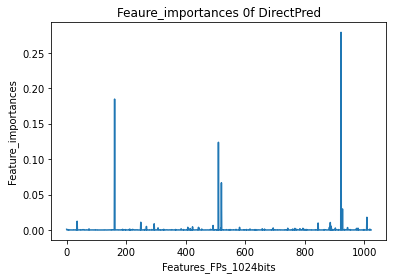

In [39]:
# Direct CCS prediction model feature importances
plotFI(rfr_Grid, 'DirectPred')

In [107]:
from rdkit.Chem import Draw
from rdkit import Chem
# get feature examples
def get_svgs(mols,ind):
    rdkbi = {}
    rdkfp = Chem.RDKFingerprint(mols, 2, fpSize = 1024, bitInfo=rdkbi)
    svg = Draw.DrawRDKitBit(mols, ind, rdkbi, useSVG=True)
    return(svg)

In [108]:
#for i in ind:
import random
def random_indices(feature):
    indices = []
    while len(indices) <6:
        j = random.randint(0,13324)
        if df_all['FPs'][j][feature] == 1:
            indices.append(j)
    return indices

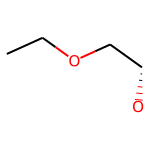

In [110]:
from IPython.core.display import display
indices922 = random_indices(922)
random_mols = random.choice(indices922)
mols = df_all['Molecules'] [random_mols]
svg = get_svgs(mols, 922)
display(svg)